In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from dataclasses import dataclass
from typing import List, Tuple
import pandas as pd

In [2]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [3]:
@dataclass
class SimulationParams:
    """Parameters for M/M/1/1 queuing system"""
    lambda_rate: float      # Arrival rate
    mu_rate: float          # Service rate
    theta: float            # Mean revenue per contract
    eta: float              # Mean lost revenue per rejection
    cost_rate: float        # Cost per unit time
    sim_time: float         # Simulation time horizon
    num_runs: int           # Number of simulation replications
    days_threshold: float   # Threshold for long contracts (in days)

    def __post_init__(self):
        """Validate parameters"""
        assert self.lambda_rate > 0, "Arrival rate must be positive"
        assert self.mu_rate > 0, "Service rate must be positive"
        assert self.sim_time > 0, "Simulation time must be positive"
        assert self.num_runs > 0, "Number of runs must be positive"

In [4]:
@dataclass
class TheoreticalResults:
    """Theoretical predictions from M/M/1/1 model"""
    P0: float               # Probability system is idle
    P1: float               # Probability system is busy (utilization)
    avg_revenue_rate: float # Expected revenue per unit time
    avg_loss_rate: float    # Expected loss per unit time
    net_revenue_rate: float # Net revenue per unit time
    completion_rate: float  # Rate of contract completions
    rejection_rate: float   # Rate of contract rejections
    long_contracts_rate: float  # Rate of contracts exceeding D days

def calculate_theoretical(params: SimulationParams) -> TheoreticalResults:
    """Calculate theoretical values for M/M/1/1 system"""
    lam = params.lambda_rate
    mu = params.mu_rate
    theta = params.theta
    eta = params.eta
    c = params.cost_rate
    D = params.days_threshold

    # Stationary distribution
    P0 = mu / (lam + mu)
    P1 = lam / (lam + mu)

    # Revenue and loss rates
    avg_revenue_rate = (theta * lam * mu) / (lam + mu)
    avg_loss_rate = (eta * lam * lam) / (lam + mu)
    net_revenue_rate = avg_revenue_rate - avg_loss_rate - c

    # Completion and rejection rates
    completion_rate = lam * mu / (lam + mu)
    rejection_rate = lam * lam / (lam + mu)

    # Long contracts rate
    long_contracts_rate = (lam * mu / (lam + mu)) * np.exp(-mu * D)

    return TheoreticalResults(
        P0=P0, P1=P1,
        avg_revenue_rate=avg_revenue_rate,
        avg_loss_rate=avg_loss_rate,
        net_revenue_rate=net_revenue_rate,
        completion_rate=completion_rate,
        rejection_rate=rejection_rate,
        long_contracts_rate=long_contracts_rate
    )

In [5]:
@dataclass
class SimulationResult:
    """Results from a single simulation run"""
    avg_revenue_rate: float
    avg_loss_rate: float
    net_revenue_rate: float
    utilization: float
    completion_rate: float
    rejection_rate: float
    long_contracts_rate: float
    time_series: pd.DataFrame  # For trajectory plots

def run_single_simulation(params: SimulationParams,
                         track_trajectory: bool = False) -> SimulationResult:
    """
    Run a single M/M/1/1 queuing simulation using event-driven approach

    Events:
    - Arrival: Contract arrives (Poisson with rate lambda)
    - Completion: Contract finishes (Exponential service time with rate mu)
    """
    time = 0.0
    state = 0  # 0 = idle, 1 = busy

    # Accumulators
    total_revenue = 0.0
    total_loss = 0.0
    contracts_completed = 0
    contracts_rejected = 0
    time_in_service = 0.0
    long_contracts_count = 0
    current_service_start = 0.0

    # Trajectory tracking
    trajectory = [] if track_trajectory else None
    trajectory_sample_interval = params.sim_time / 1000  # Record 1000 points
    next_sample_time = 0.0

    # Initialize event times
    next_arrival = np.random.exponential(1.0 / params.lambda_rate)
    next_completion = np.inf

    while time < params.sim_time:
        # Record trajectory
        if track_trajectory and time >= next_sample_time:
            trajectory.append({
                'time': time,
                'state': state,
                'cumulative_revenue': total_revenue,
                'cumulative_loss': total_loss,
                'utilization': time_in_service / time if time > 0 else 0,
                'avg_revenue_rate': total_revenue / time if time > 0 else 0,
                'contracts_completed': contracts_completed,
                'contracts_rejected': contracts_rejected
            })
            next_sample_time += trajectory_sample_interval

        # Determine next event
        if next_arrival < next_completion:
            # Arrival event
            time = next_arrival

            if state == 0:
                # System idle - accept contract
                state = 1
                current_service_start = time

                # Generate service time
                service_time = np.random.exponential(1.0 / params.mu_rate)
                next_completion = time + service_time

                # Check if this will be a long contract
                if service_time > params.days_threshold:
                    long_contracts_count += 1
            else:
                # System busy - reject contract
                contracts_rejected += 1
                # Add variability to loss (±20% around mean)
                loss = params.eta * (0.8 + 0.4 * np.random.random())
                total_loss += loss

            # Schedule next arrival
            next_arrival = time + np.random.exponential(1.0 / params.lambda_rate)

        else:
            # Completion event
            time = next_completion

            # Update service time accumulator
            service_duration = time - current_service_start
            time_in_service += service_duration

            # Complete contract
            state = 0
            contracts_completed += 1

            # Add variability to revenue (±20% around mean)
            revenue = params.theta * (0.8 + 0.4 * np.random.random())
            total_revenue += revenue

            # No completion scheduled
            next_completion = np.inf

    # Calculate rates
    avg_revenue_rate = total_revenue / time
    avg_loss_rate = total_loss / time
    net_revenue_rate = (total_revenue - total_loss) / time - params.cost_rate
    utilization = time_in_service / time
    completion_rate = contracts_completed / time
    rejection_rate = contracts_rejected / time
    long_contracts_rate = long_contracts_count / time

    trajectory_df = pd.DataFrame(trajectory) if track_trajectory else None

    return SimulationResult(
        avg_revenue_rate=avg_revenue_rate,
        avg_loss_rate=avg_loss_rate,
        net_revenue_rate=net_revenue_rate,
        utilization=utilization,
        completion_rate=completion_rate,
        rejection_rate=rejection_rate,
        long_contracts_rate=long_contracts_rate,
        time_series=trajectory_df
    )

def run_multiple_simulations(params: SimulationParams) -> Tuple[List[SimulationResult], SimulationResult]:
    """Run multiple simulation replications"""
    print(f"Running {params.num_runs} simulations...")

    results = []
    for i in range(params.num_runs):
        if (i + 1) % 10 == 0:
            print(f"  Completed {i + 1}/{params.num_runs} runs")

        # Track trajectory only for first run
        track = (i == 0)
        result = run_single_simulation(params, track_trajectory=track)
        results.append(result)

    print("Simulations complete!")
    return results, results[0]  # Return all results and first run for trajectory

In [6]:
def create_comparison_table(params: SimulationParams,
                           theoretical: TheoreticalResults,
                           results: List[SimulationResult]) -> pd.DataFrame:
    """Create comparison table of theoretical vs simulated results"""

    # Calculate simulation statistics
    metrics = {
        'Utilization (P₁)': (
            'utilization',
            theoretical.P1,
            '%'
        ),
        'Avg Revenue Rate': (
            'avg_revenue_rate',
            theoretical.avg_revenue_rate,
            '$/time'
        ),
        'Avg Loss Rate': (
            'avg_loss_rate',
            theoretical.avg_loss_rate,
            '$/time'
        ),
        'Net Revenue Rate': (
            'net_revenue_rate',
            theoretical.net_revenue_rate,
            '$/time'
        ),
        'Completion Rate': (
            'completion_rate',
            theoretical.completion_rate,
            'contracts/time'
        ),
        'Rejection Rate': (
            'rejection_rate',
            theoretical.rejection_rate,
            'contracts/time'
        ),
        'Long Contracts Rate': (
            'long_contracts_rate',
            theoretical.long_contracts_rate,
            'contracts/time'
        )
    }

    rows = []
    for metric_name, (attr, theo_val, unit) in metrics.items():
        values = [getattr(r, attr) for r in results]
        sim_mean = np.mean(values)
        sim_std = np.std(values)

        # Calculate percentage error
        if abs(theo_val) > 1e-6:
            error_pct = abs((theo_val - sim_mean) / theo_val * 100)
        else:
            error_pct = 0.0

        # For utilization, convert to percentage
        if 'Utilization' in metric_name:
            theo_val *= 100
            sim_mean *= 100
            sim_std *= 100

        rows.append({
            'Metric': metric_name,
            'Theoretical': f'{theo_val:.4f}',
            'Simulated Mean': f'{sim_mean:.4f}',
            'Simulated Std': f'{sim_std:.4f}',
            'Unit': unit,
            'Error (%)': f'{error_pct:.2f}'
        })

    return pd.DataFrame(rows)




In [7]:
def plot_validation_results(params: SimulationParams,
                           theoretical: TheoreticalResults,
                           results: List[SimulationResult],
                           trajectory: SimulationResult):
    """Create comprehensive validation plots"""

    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # 1. Utilization Distribution
    ax1 = fig.add_subplot(gs[0, 0])
    utilizations = [r.utilization * 100 for r in results]
    ax1.hist(utilizations, bins=30, alpha=0.7, edgecolor='black', density=True)
    ax1.axvline(theoretical.P1 * 100, color='red', linestyle='--', linewidth=2,
                label=f'Theoretical: {theoretical.P1*100:.2f}%')
    ax1.axvline(np.mean(utilizations), color='blue', linestyle='--', linewidth=2,
                label=f'Simulated: {np.mean(utilizations):.2f}%')
    ax1.set_xlabel('Utilization (%)')
    ax1.set_ylabel('Density')
    ax1.set_title('System Utilization Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Revenue Rate Distribution
    ax2 = fig.add_subplot(gs[0, 1])
    revenues = [r.avg_revenue_rate for r in results]
    ax2.hist(revenues, bins=30, alpha=0.7, color='green', edgecolor='black', density=True)
    ax2.axvline(theoretical.avg_revenue_rate, color='red', linestyle='--', linewidth=2,
                label=f'Theoretical: ${theoretical.avg_revenue_rate:.2f}')
    ax2.axvline(np.mean(revenues), color='blue', linestyle='--', linewidth=2,
                label=f'Simulated: ${np.mean(revenues):.2f}')
    ax2.set_xlabel('Average Revenue Rate ($/time)')
    ax2.set_ylabel('Density')
    ax2.set_title('Revenue Rate Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Net Revenue Distribution
    ax3 = fig.add_subplot(gs[0, 2])
    net_revenues = [r.net_revenue_rate for r in results]
    ax3.hist(net_revenues, bins=30, alpha=0.7, color='purple', edgecolor='black', density=True)
    ax3.axvline(theoretical.net_revenue_rate, color='red', linestyle='--', linewidth=2,
                label=f'Theoretical: ${theoretical.net_revenue_rate:.2f}')
    ax3.axvline(np.mean(net_revenues), color='blue', linestyle='--', linewidth=2,
                label=f'Simulated: ${np.mean(net_revenues):.2f}')
    ax3.set_xlabel('Net Revenue Rate ($/time)')
    ax3.set_ylabel('Density')
    ax3.set_title('Net Revenue Rate Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Q-Q Plot for Utilization
    ax4 = fig.add_subplot(gs[1, 0])
    stats.probplot(utilizations, dist="norm", plot=ax4)
    ax4.set_title('Q-Q Plot: Utilization Normality')
    ax4.grid(True, alpha=0.3)

    # 5. Convergence Plot (Sample Path)
    ax5 = fig.add_subplot(gs[1, 1:])
    if trajectory.time_series is not None:
        df = trajectory.time_series
        ax5_twin = ax5.twinx()

        line1 = ax5.plot(df['time'], df['utilization'] * 100,
                        label='Utilization', color='blue', linewidth=1.5)
        ax5.axhline(theoretical.P1 * 100, color='red', linestyle='--',
                   linewidth=2, alpha=0.7, label='Theoretical P₁')

        line2 = ax5_twin.plot(df['time'], df['avg_revenue_rate'],
                             label='Avg Revenue Rate', color='green', linewidth=1.5)
        ax5_twin.axhline(theoretical.avg_revenue_rate, color='orange',
                        linestyle='--', linewidth=2, alpha=0.7,
                        label='Theoretical Revenue')

        ax5.set_xlabel('Time')
        ax5.set_ylabel('Utilization (%)', color='blue')
        ax5_twin.set_ylabel('Revenue Rate ($/time)', color='green')
        ax5.set_title('Sample Path: Convergence to Steady State')
        ax5.tick_params(axis='y', labelcolor='blue')
        ax5_twin.tick_params(axis='y', labelcolor='green')

        # Combine legends
        lines1, labels1 = ax5.get_legend_handles_labels()
        lines2, labels2 = ax5_twin.get_legend_handles_labels()
        ax5.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        ax5.grid(True, alpha=0.3)

    # 6. Scatter: Theoretical vs Simulated
    ax6 = fig.add_subplot(gs[2, 0])
    metrics_theo = [theoretical.P1 * 100, theoretical.avg_revenue_rate,
                    theoretical.avg_loss_rate, theoretical.completion_rate]
    metrics_sim = [np.mean([r.utilization * 100 for r in results]),
                   np.mean([r.avg_revenue_rate for r in results]),
                   np.mean([r.avg_loss_rate for r in results]),
                   np.mean([r.completion_rate for r in results])]
    labels = ['Util(%)', 'Revenue', 'Loss', 'Complete']

    ax6.scatter(metrics_theo, metrics_sim, s=100, alpha=0.7)
    for i, label in enumerate(labels):
        ax6.annotate(label, (metrics_theo[i], metrics_sim[i]),
                    xytext=(5, 5), textcoords='offset points')

    # Perfect agreement line
    min_val = min(min(metrics_theo), min(metrics_sim))
    max_val = max(max(metrics_theo), max(metrics_sim))
    ax6.plot([min_val, max_val], [min_val, max_val],
            'r--', linewidth=2, label='Perfect Agreement')
    ax6.set_xlabel('Theoretical Values')
    ax6.set_ylabel('Simulated Values')
    ax6.set_title('Theoretical vs Simulated Comparison')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    # 7. Error Analysis
    ax7 = fig.add_subplot(gs[2, 1])
    error_data = {
        'Utilization': abs(theoretical.P1 - np.mean([r.utilization for r in results])) / theoretical.P1 * 100 if theoretical.P1 > 1e-6 else 0,
        'Revenue': abs(theoretical.avg_revenue_rate - np.mean(revenues)) / theoretical.avg_revenue_rate * 100 if theoretical.avg_revenue_rate > 1e-6 else 0,
        'Loss': abs(theoretical.avg_loss_rate - np.mean([r.avg_loss_rate for r in results])) / theoretical.avg_loss_rate * 100 if theoretical.avg_loss_rate > 1e-6 else 0,
        'Net Revenue': abs(theoretical.net_revenue_rate - np.mean(net_revenues)) / abs(theoretical.net_revenue_rate) * 100 if abs(theoretical.net_revenue_rate) > 1e-6 else 0,
        'Completion': abs(theoretical.completion_rate - np.mean([r.completion_rate for r in results])) / theoretical.completion_rate * 100 if theoretical.completion_rate > 1e-6 else 0
    }

    colors = ['green' if v < 5 else 'orange' if v < 10 else 'red'
              for v in error_data.values()]
    ax7.bar(error_data.keys(), error_data.values(), color=colors, alpha=0.7, edgecolor='black')
    ax7.axhline(5, color='orange', linestyle='--', linewidth=1, label='5% threshold')
    ax7.set_ylabel('Percentage Error (%)')
    ax7.set_title('Model Validation: Percentage Errors')
    ax7.legend()
    ax7.grid(True, alpha=0.3, axis='y')
    plt.setp(ax7.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # 8. Confidence Intervals
    ax8 = fig.add_subplot(gs[2, 2])
    metrics_for_ci = ['Utilization', 'Revenue\nRate', 'Net\nRevenue', 'Completion\nRate']
    means = [np.mean([r.utilization * 100 for r in results]),
             np.mean(revenues),
             np.mean(net_revenues),
             np.mean([r.completion_rate for r in results])]
    stds = [np.std([r.utilization * 100 for r in results]),
            np.std(revenues),
            np.std(net_revenues),
            np.std([r.completion_rate for r in results])]
    theoretical_vals = [theoretical.P1 * 100,
                       theoretical.avg_revenue_rate,
                       theoretical.net_revenue_rate,
                       theoretical.completion_rate]

    # Normalize for visualization, handle potential division by zero
    normalized_means = [means[i] / theoretical_vals[i] if theoretical_vals[i] != 0 else 0 for i in range(len(means))]
    normalized_stds = [stds[i] / theoretical_vals[i] if theoretical_vals[i] != 0 else 0 for i in range(len(stds))]


    x_pos = np.arange(len(metrics_for_ci))
    ax8.bar(x_pos, normalized_means, alpha=0.6, label='Simulated Mean')
    ax8.errorbar(x_pos, normalized_means, yerr=[1.96 * s for s in normalized_stds],
                fmt='none', ecolor='black', capsize=5, label='95% CI')
    ax8.axhline(1.0, color='red', linestyle='--', linewidth=2, label='Theoretical')
    ax8.set_xticks(x_pos)
    ax8.set_xticklabels(metrics_for_ci)
    ax8.set_ylabel('Normalized Value (Simulated/Theoretical)')
    ax8.set_title('Confidence Intervals (95%)')
    ax8.legend()
    ax8.grid(True, alpha=0.3, axis='y')

    plt.suptitle(f'M/M/1/1 Model Validation: λ={params.lambda_rate}, μ={params.mu_rate}, ρ={params.lambda_rate/params.mu_rate:.3f}',
                 fontsize=16, fontweight='bold', y=0.995)

    return fig


In [8]:
def plot_sensitivity_analysis(base_params: SimulationParams):
    """Analyze how net revenue changes with lambda and mu"""
    print("\nRunning sensitivity analysis...")

    # Vary lambda
    lambda_values = np.linspace(0.5, 4.5, 15)
    mu_fixed = base_params.mu_rate

    net_revenues_lambda = []
    theoretical_lambda = []

    for lam in lambda_values:
        params = SimulationParams(
            lambda_rate=lam,
            mu_rate=mu_fixed,
            theta=base_params.theta,
            eta=base_params.eta,
            cost_rate=base_params.cost_rate,
            sim_time=5000,  # Shorter for speed
            num_runs=20,
            days_threshold=base_params.days_threshold
        )

        theoretical = calculate_theoretical(params)
        results = [run_single_simulation(params, track_trajectory=False)
                  for _ in range(params.num_runs)]

        net_revenues_lambda.append(np.mean([r.net_revenue_rate for r in results]))
        theoretical_lambda.append(theoretical.net_revenue_rate)

    # Vary mu
    lambda_fixed = base_params.lambda_rate
    mu_values = np.linspace(1.5, 5.5, 15)

    net_revenues_mu = []
    theoretical_mu = []

    for mu in mu_values:
        params = SimulationParams(
            lambda_rate=lambda_fixed,
            mu_rate=mu,
            theta=base_params.theta,
            eta=base_params.eta,
            cost_rate=base_params.cost_rate,
            sim_time=5000,
            num_runs=20,
            days_threshold=base_params.days_threshold
        )

        theoretical = calculate_theoretical(params)
        results = [run_single_simulation(params, track_trajectory=False)
                  for _ in range(params.num_runs)]

        net_revenues_mu.append(np.mean([r.net_revenue_rate for r in results]))
        theoretical_mu.append(theoretical.net_revenue_rate)

    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Lambda sensitivity
    ax1.plot(lambda_values, theoretical_lambda, 'r--', linewidth=2,
            label='Theoretical', marker='o')
    ax1.plot(lambda_values, net_revenues_lambda, 'b-', linewidth=2,
            label='Simulated', marker='s')
    ax1.axhline(0, color='black', linestyle=':', linewidth=1)
    ax1.set_xlabel('Arrival Rate (λ)')
    ax1.set_ylabel('Net Revenue Rate ($/time)')
    ax1.set_title(f'Sensitivity to Arrival Rate (μ={mu_fixed} fixed)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Mu sensitivity
    ax2.plot(mu_values, theoretical_mu, 'r--', linewidth=2,
            label='Theoretical', marker='o')
    ax2.plot(mu_values, net_revenues_mu, 'b-', linewidth=2,
            label='Simulated', marker='s')
    ax2.axhline(0, color='black', linestyle=':', linewidth=1)
    ax2.set_xlabel('Service Rate (μ)')
    ax2.set_ylabel('Net Revenue Rate ($/time)')
    ax2.set_title(f'Sensitivity to Service Rate (λ={lambda_fixed} fixed)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.suptitle('Sensitivity Analysis: Net Revenue Optimization',
                fontsize=14, fontweight='bold')
    plt.tight_layout()

    return fig

M/M/1/1 QUEUING MODEL VALIDATION

Simulation Parameters:
  Arrival rate (λ): 2.0
  Service rate (μ): 3.0
  Traffic intensity (ρ): 0.667
  Mean revenue per contract (θ): $1000.0
  Mean lost revenue (η): $800.0
  Cost rate: $100.0/time
  Simulation time: 10000.0
  Number of runs: 100
  Days threshold: 1.0

THEORETICAL RESULTS
  System utilization (P₁): 40.00%
  Idle probability (P₀): 60.00%
  Average revenue rate: $1200.00/time
  Average loss rate: $640.00/time
  Net revenue rate: $460.00/time
  Completion rate: 1.2000 contracts/time
  Rejection rate: 0.8000 contracts/time
  Long contracts rate: 0.0597 contracts/time

RUNNING SIMULATIONS
Running 100 simulations...
  Completed 10/100 runs
  Completed 20/100 runs
  Completed 30/100 runs
  Completed 40/100 runs
  Completed 50/100 runs
  Completed 60/100 runs
  Completed 70/100 runs
  Completed 80/100 runs
  Completed 90/100 runs
  Completed 100/100 runs
Simulations complete!

VALIDATION RESULTS
             Metric Theoretical Simulated Mean

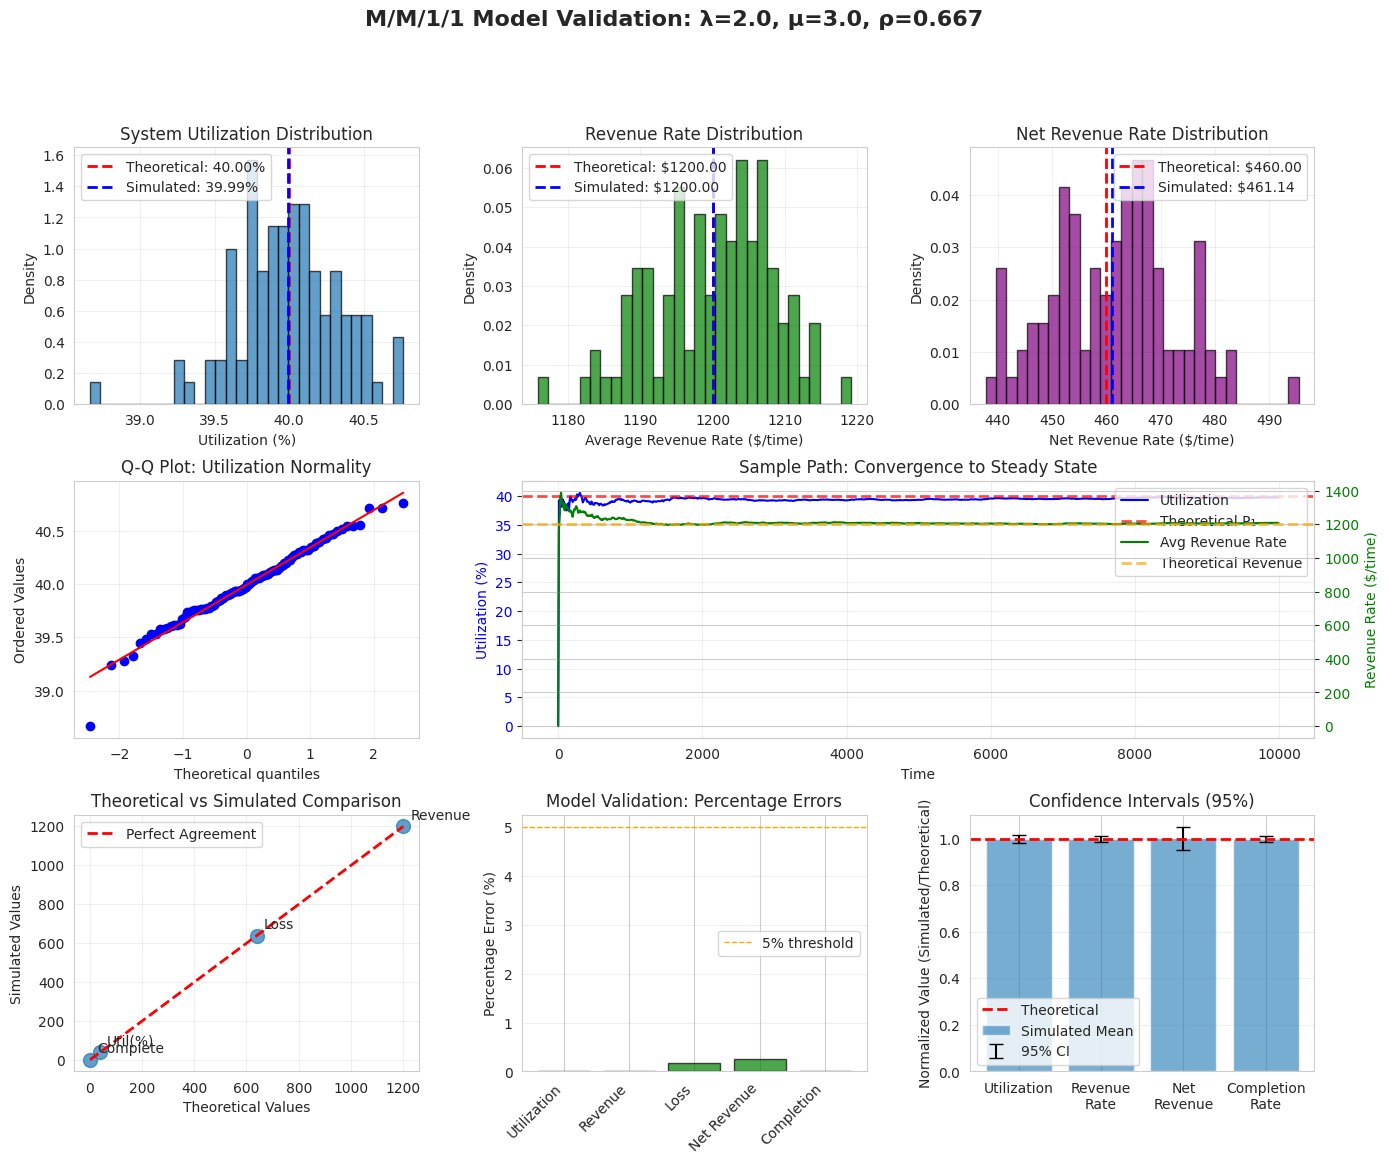

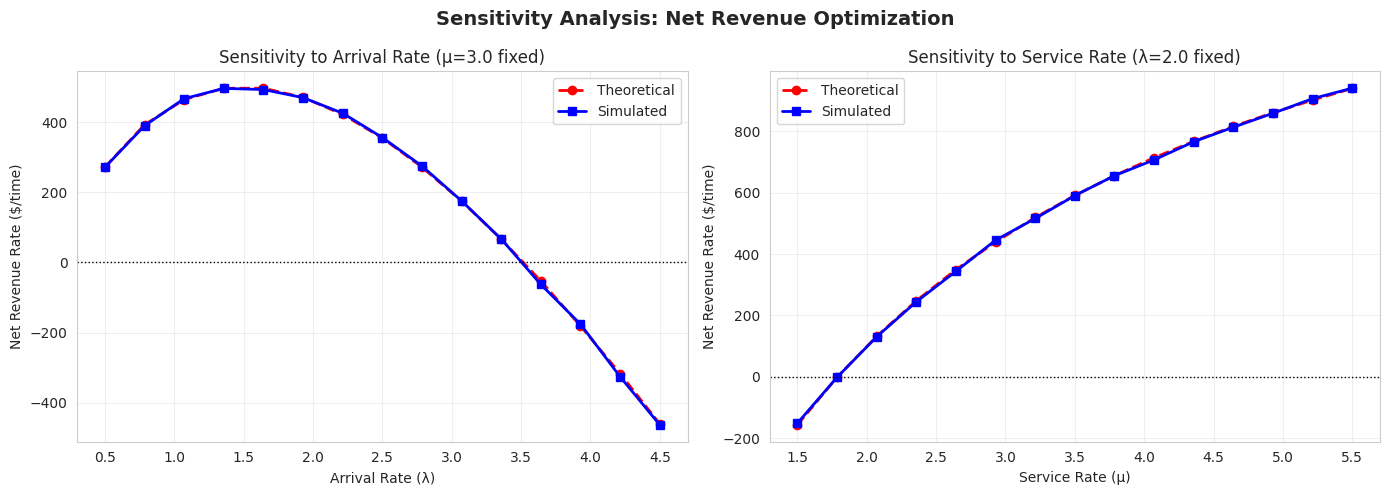

In [9]:
def main():
    """Main execution function"""

    # Define simulation parameters
    params = SimulationParams(
        lambda_rate=2.0,      # 2 contracts arrive per time unit on average
        mu_rate=3.0,          # Can complete 3 contracts per time unit on average
        theta=1000.0,         # $1000 average revenue per contract
        eta=800.0,            # $800 average lost revenue per rejection
        cost_rate=100.0,      # $100 per time unit operational cost
        sim_time=10000.0,     # Simulate for 10000 time units
        num_runs=100,         # 100 independent replications
        days_threshold=1.0    # Interested in contracts > 1 day
    )

    print("=" * 70)
    print("M/M/1/1 QUEUING MODEL VALIDATION")
    print("=" * 70)
    print(f"\nSimulation Parameters:")
    print(f"  Arrival rate (λ): {params.lambda_rate}")
    print(f"  Service rate (μ): {params.mu_rate}")
    print(f"  Traffic intensity (ρ): {params.lambda_rate/params.mu_rate:.3f}")
    print(f"  Mean revenue per contract (θ): ${params.theta}")
    print(f"  Mean lost revenue (η): ${params.eta}")
    print(f"  Cost rate: ${params.cost_rate}/time")
    print(f"  Simulation time: {params.sim_time}")
    print(f"  Number of runs: {params.num_runs}")
    print(f"  Days threshold: {params.days_threshold}")

    # Calculate theoretical results
    print("\n" + "=" * 70)
    print("THEORETICAL RESULTS")
    print("=" * 70)
    theoretical = calculate_theoretical(params)
    print(f"  System utilization (P₁): {theoretical.P1*100:.2f}%")
    print(f"  Idle probability (P₀): {theoretical.P0*100:.2f}%")
    print(f"  Average revenue rate: ${theoretical.avg_revenue_rate:.2f}/time")
    print(f"  Average loss rate: ${theoretical.avg_loss_rate:.2f}/time")
    print(f"  Net revenue rate: ${theoretical.net_revenue_rate:.2f}/time")
    print(f"  Completion rate: {theoretical.completion_rate:.4f} contracts/time")
    print(f"  Rejection rate: {theoretical.rejection_rate:.4f} contracts/time")
    print(f"  Long contracts rate: {theoretical.long_contracts_rate:.4f} contracts/time")

    # Run simulations
    print("\n" + "=" * 70)
    print("RUNNING SIMULATIONS")
    print("=" * 70)
    results, trajectory = run_multiple_simulations(params)

    # Create comparison table
    print("\n" + "=" * 70)
    print("VALIDATION RESULTS")
    print("=" * 70)
    comparison_df = create_comparison_table(params, theoretical, results)
    print(comparison_df.to_string(index=False))

    # Statistical summary
    print("\n" + "=" * 70)
    print("STATISTICAL SUMMARY")
    print("=" * 70)
    utilizations = [r.utilization for r in results]
    revenues = [r.avg_revenue_rate for r in results]
    net_revenues = [r.net_revenue_rate for r in results]

    print(f"\nUtilization:")
    print(f"  Mean: {np.mean(utilizations)*100:.2f}%")
    print(f"  Std Dev: {np.std(utilizations)*100:.2f}%")
    print(f"  95% CI: [{np.percentile(utilizations, 2.5)*100:.2f}%, {np.percentile(utilizations, 97.5)*100:.2f}%]")

    print(f"\nRevenue Rate:")
    print(f"  Mean: ${np.mean(revenues):.2f}/time")
    print(f"  Std Dev: ${np.std(revenues):.2f}/time")
    print(f"  95% CI: [${np.percentile(revenues, 2.5):.2f}, ${np.percentile(revenues, 97.5):.2f}]")

    print(f"\nNet Revenue Rate:")
    print(f"  Mean: ${np.mean(net_revenues):.2f}/time")
    print(f"  Std Dev: ${np.std(net_revenues):.2f}/time")
    print(f"  95% CI: [${np.percentile(net_revenues, 2.5):.2f}, ${np.percentile(net_revenues, 97.5):.2f}]")

    # Create validation plots
    print("\n" + "=" * 70)
    print("GENERATING PLOTS")

    plot_validation_results(params, theoretical, results, trajectory)
    plot_sensitivity_analysis(params)

    plt.show()

main()